# Ron Eval

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import pytz
import numpy as np
import torch
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator
from gluonts.transform.feature import MissingValueImputation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_log_error

frequency = "1d"

# Define the time zone
pacific_tz = pytz.timezone('US/Pacific')

# Define start and end times in Pacific Time
start_time = pacific_tz.localize(datetime(2012, 1, 1)).strftime('%Y-%m-%d')
end_time = pacific_tz.localize(datetime(2024, 3, 12)).strftime('%Y-%m-%d')

tickers = ["BTC-CAD"]

# Retrieve and concatenate historical data
df = pd.concat(
    [yf.download(ticker, start=start_time, end=end_time, interval=frequency)[['High', 'Low']].add_prefix(f"{ticker}_") for ticker in tickers],
    axis=1
)

torch.set_float32_matmul_precision('high')

target_column_high = 'BTC-CAD_High'
target_column_low = 'BTC-CAD_Low'

df.index = pd.to_datetime(df.index)
df = df.asfreq("D")

prediction_length = 1
context_length = 60
recent_days = 8  # Number of most recent days to consider for the forecast

model_high = 'ron_high_huge.pth'
model_low = 'ron_low_huge.pth'

predictor_high = torch.load(model_high)
predictor_low = torch.load(model_low)

def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


def perform_rolling_evaluation(df, predictor, target_column, context_length, recent_days):
    daily_metrics = []
    temp_df = df.copy()  # Create a temporary DataFrame to modify

    for day in range(recent_days):
        start_index = len(temp_df) - recent_days + day
        end_index = start_index + 1

        if end_index >= len(df):  # Use the original df for actual value check
            continue

        # Use modified temp_df for test data to include previous forecasts
        test_data = ListDataset([
            {
                "start": temp_df.index[start_index - context_length],
                "target": temp_df[target_column][start_index - context_length:start_index].values
            }
        ], freq='D')

        forecast = next(predictor.predict(test_data))
        predicted_value = forecast.quantile(0.5)[0]
        
        # Update temp_df with the forecasted value for the next prediction
        if end_index < len(temp_df):
            temp_df.at[temp_df.index[end_index], target_column] = predicted_value

        actual_value = df[target_column].iloc[end_index]  # Actual value from original df

        # Error calculations based on actual value
        error = abs(predicted_value - actual_value)
        squared_error = (predicted_value - actual_value) ** 2
        ape = np.abs((predicted_value - actual_value) / actual_value) * 100

        # Calculate daily metrics
        mse = mean_squared_error([actual_value], [predicted_value])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error([actual_value], [predicted_value])
        mape = calculate_mape([actual_value], [predicted_value])
        smape = calculate_smape([actual_value], [predicted_value])

        daily_metrics.append({
            "Day": day+1, "MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape,
            "sMAPE": smape
        })

    return daily_metrics


[*********************100%%**********************]  1 of 1 completed


In [2]:
# Perform evaluation for the high and low models
daily_metrics_high = perform_rolling_evaluation(df, predictor_high, target_column_high, context_length, recent_days)
daily_metrics_low = perform_rolling_evaluation(df, predictor_low, target_column_low, context_length, recent_days)

# Print daily metrics
for day_metric in daily_metrics_high:
    print(f"Day {day_metric['Day']} High Model Metrics:", day_metric)

for day_metric in daily_metrics_low:
    print(f"Day {day_metric['Day']} Low Model Metrics:", day_metric)


Day 1 High Model Metrics: {'Day': 1, 'MSE': 54657142.095947266, 'RMSE': 7393.046875, 'MAE': 7393.046875, 'MAPE': 7.94568143385162, 'sMAPE': 8.27441058672672}
Day 2 High Model Metrics: {'Day': 2, 'MSE': 39413382.093811035, 'RMSE': 6278.0078125, 'MAE': 6278.0078125, 'MAPE': 6.692058545112986, 'sMAPE': 6.923728528426482}
Day 3 High Model Metrics: {'Day': 3, 'MSE': 13689364.069885254, 'RMSE': 3699.9140625, 'MAE': 3699.9140625, 'MAPE': 4.025281325762637, 'sMAPE': 4.107959795011862}
Day 4 High Model Metrics: {'Day': 4, 'MSE': 576187.7393188477, 'RMSE': 759.0703125, 'MAE': 759.0703125, 'MAPE': 0.8282404232063827, 'sMAPE': 0.8316845972202623}
Day 5 High Model Metrics: {'Day': 5, 'MSE': 41584462.11187744, 'RMSE': 6448.6015625, 'MAE': 6448.6015625, 'MAPE': 6.834892039358503, 'sMAPE': 7.076735660511889}
Day 6 High Model Metrics: {'Day': 6, 'MSE': 160368.9624633789, 'RMSE': 400.4609375, 'MAE': 400.4609375, 'MAPE': 0.4310783805096966, 'sMAPE': 0.43200953035324385}
Day 7 High Model Metrics: {'Day': 

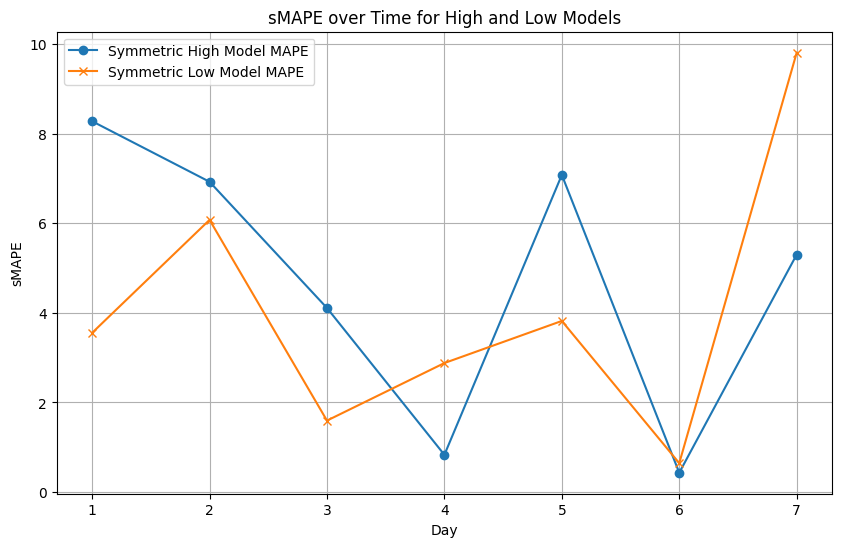

In [3]:
days = [metric["Day"] for metric in daily_metrics_high]  # Assuming same days for high and low

# Extracting MAPE metrics
mape_high = [metric["sMAPE"] for metric in daily_metrics_high]
mape_low = [metric["sMAPE"] for metric in daily_metrics_low]

# Plotting MAPE as a time series
plt.figure(figsize=(10, 6))
plt.plot(days, mape_high, label='Symmetric High Model MAPE', marker='o')
plt.plot(days, mape_low, label='Symmetric Low Model MAPE', marker='x')
plt.xlabel('Day')
plt.ylabel('sMAPE')
plt.title('sMAPE over Time for High and Low Models')
plt.legend()
plt.grid(True)
plt.show()
